## TANGO Tutorial: Virus-Like Particles

This Tutorial was designed to demonstrate the usage of cryoCAT and its module tango.py for the affiliation computation of immature HIV virus-like particles (VLPs), and some subsequent analyisis.

### Note on GUI:

To access the TANGO graphical user interface (GUI), you have two options (make sure you are in the environment where **cryocat** is installed):

1. Navigate to the `/cryocat/app/` folder and run:

   ```bash
   python app.py
   ```
2. Alternatively, simply type the following in the command line:

   ```bash
   tango_app
   ```

   **Note:** If you installed **cryocat** in editable mode (recommended) *before* `tango_app` was added, you will need to reinstall it to have the `tango_app` command properly registered.

**Important:** Neither of these commands will open the GUI directly. Instead, they will start a local server and display an address in the terminal, such as:

```
Running on http://127.0.0.1:8050
```

Copy this address into your browser to access the GUI.

For an introduction on how to use the GUI, consider watching [this video](https://oc.biophys.mpg.de/owncloud/s/Bo39F2K5HRK2LPf).


### Preparation of Notebook

autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.

In [1]:
%load_ext autoreload
%autoreload 2

Besides the cryoCAT modules to handle motive lists (cryomotl) and the module dedicated to twist-aware neighborhoods for geometric organization (TANGO), several other common python libraries are imported for this demonstration.

In [ ]:
import numpy as np

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt

from cryocat import cryomotl, tango

# for color palette
from monet_palette import monet_colors

### Input

The VLP motive list is loaded. The data was generated from bin1 tomograms with a pixel size of 1.329 Angstrom. 

In [3]:
vlp_input = "./inputs/allmotl_qc_sc50_1_hiv_virus_like_particles.em"

distance_scale = dist_scale = 1.329 / 2 # Å/px (HIV VLPs bin1: 1.329 Å/px) # Data is bin2

vlp_motl = cryomotl.EmMotl(vlp_input)

### Parameter Analysis

Nearest neighbors (NNs) and their distances are gained using cKDTree. 

The search radius for the initial TwistDescriptor depends on NN-statistics.

It is chosen so as to have non-empty supports for most subunits (SUs), while not being too large, either. The purpose of choosing a smaller spherical support stems from wanting to compute affiliations.

Some VLPs may be very close to eachother and one wishes to mostly have SUs from the same VLP within a given support. Hwever, a subsequent cleaning step will anyway be used to further ensure this.

Better safe than sorry.

In [4]:
positions = vlp_motl.get_coordinates()

tree = cKDTree(positions)

dd, _ = tree.query(positions, k=2)

radius = np.median(dd[:,1]) + 5 * np.std(dd[:,1]) 

print(f"The search radius for the twist descriptor computation is {radius * distance_scale / 10} nm.")

The search radius for the twist descriptor computation is 3.7615309896214404 nm.


### Computation of Twist Features

In [ ]:
vlp_twist_desc = tango.TwistDescriptor(input_motl= vlp_motl, nn_radius= 3 * radius)

display(vlp_twist_desc.df)

Among the support options offered by TANGO, the cylindrical support together with the option symmetric= False is a well-suited support to crop the initial one to.

In the context of a given VLP, a subunit's intrinsic z-axis serves as an outward pointing normal to the surface. 

Thus, a cylinder extending from a SU inwards in the oppsite direction should ideally contain mostly SUs of the same VLP.

In [ ]:
cylinder_supp = tango.Cylinder(vlp_twist_desc, radius= 3* radius, height=radius / 15, axis = np.array([0,0,-1]), symmetric= False)

display(cylinder_supp.support.df)

An extra cautionary step was included. This one filters the cylindrical support further based on how much the overall relative rotations deviate from a rotation around the intrinsic z-axis. 

Small deviations hint at close neighboring SUs of the same VLP. 

A max_angle describes the tolerance of this deviation. The feature to look out for in this case is 'rot_angle_z', which is the default option for tango.AxisRot().

In [ ]:
max_angle = np.degrees(0.1)

z_axis_filtered = tango.AxisRot(twist_desc= cylinder_supp.support, max_angle= max_angle)

display(z_axis_filtered.filter.df)

Intersecting supports can be deduced from a data frame by treating subtomogram ids as nodes in a graph and connecting them whenever they form a 'qp_id'--'nn_id'--pair in a given row of that data frame.

The resulting graph decomposes into connected components which are computed from a twist descriptor using the proximity clustering method.

Here, it is applied to the most recent cleaning results. There are 32 VLPs in the data, but due to sparsity, let us look for the 35 biggest connected components.

In [8]:
S = z_axis_filtered.filter.proximity_clustering(num_connected_components= 35)

Each connected component is a networkx Graph object, the nodes of which are subtomogram ids, which can be used to get subsets of the input motivelist in order to label that sublist, before concatenating them into the output motive list.

In [9]:
out_motl = cryomotl.Motl()

for i, G in enumerate(S):

    subtomo_indices = list(set(G.nodes()))

    sub_motl = vlp_motl.get_motl_subset(subtomo_indices, feature_id= 'subtomo_id')

    sub_motl.df['geom1'] = i * np.ones(sub_motl.df['geom1'].shape[0])

    out_motl = out_motl + sub_motl

out_motl.write_out('vlp_components_tutorial.em')

Note that while some sparse data points are not included in this result, some VLPs are represented using more than one connected component in the sense of the graph structure explained above. 

This can be improved with parameter tweaking. A bigger support radius, for example, would help catch more SU of a given VLP within a given support.

However, other cleaning steps, such as the filtering with respect to z-normal deviation, are sensitive to VLP curvature. The relevant parameters might have to be increased accordingly.

### Lattice analysis

Next, we investigate symmetry properties of these lattices.

To do so, let us again compute the TwistDescriptor, but now let us do it under the assumption of C_6 symmetry.

This assumption makes it so that the ``angular score'' is computed. 

As far as I know, this score is being introduces in TANGO. It reflects how well data fits into, for example, C_6 symmetry.

On top of that, it does so in an unambiguous manner, as it is not provided by the angular distance alone.

In [10]:
vlp_twist_desc_symm = tango.TwistDescriptor(input_motl= vlp_motl, nn_radius= radius, symm= 6)

Now we can simply repeat the same data frame processing steps from before to end up with information associated to (patches of) individual VLPs.

In [11]:
cylinder_supp_symm = tango.Cylinder(vlp_twist_desc_symm, radius=radius, height=radius / 15, axis = np.array([0,0,-1]), symmetric= False)

z_axis_filtered_symm = tango.AxisRot(twist_desc= cylinder_supp_symm.support, max_angle= max_angle)

In [ ]:
display(z_axis_filtered_symm.filter.df)

One can now investigate the angular scores -- how regular are the lattices in the data in the context of C_6 symmetry?

What VLP has the highest average angular score?

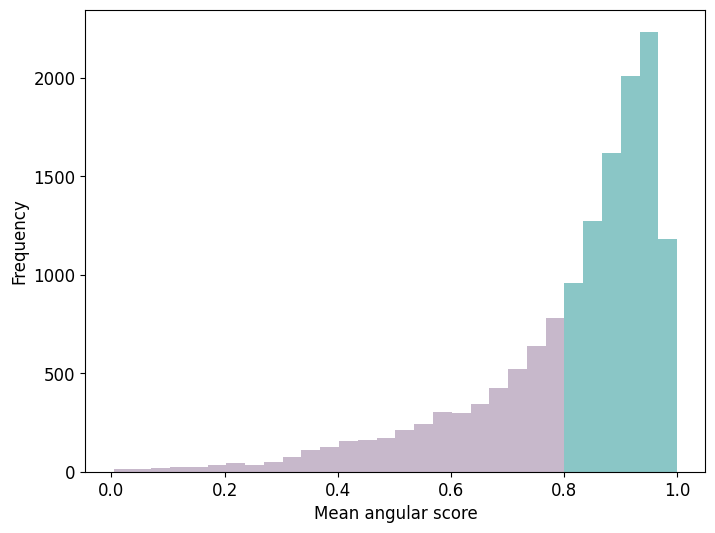

Proportion of data with mean angular score above 0.8: 0.6594521714447914


In [13]:
df = z_axis_filtered_symm.filter.df.copy()

df = df[df['euclidean_distance'] < 35] ## to catch the first shells.

mean_distances_whole = df.groupby(['qp_id', 'tomo_id'])['angular_score'].mean().to_dict()

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})

# Compute histogram and keep patches to modify individual bars
counts, bins, patches = plt.hist(mean_distances_whole.values(), bins=30, color=monet_colors[5], alpha=0.7)

# Paint bars to the right of x = 0.8 in green
for bin_left, patch in zip(bins[:-1], patches):
    if bin_left >= 0.8:
        patch.set_facecolor(monet_colors[2])

plt.xlabel('Mean angular score')
plt.ylabel('Frequency')

plt.show()

###
data = df.groupby(['qp_id', 'tomo_id'])['angular_score'].mean().to_numpy()
print(f"Proportion of data with mean angular score above 0.8: {np.count_nonzero(data >= 0.8) / len(data)}")

It may be interesting to see how the same result looks for different types of C_n symmetry.

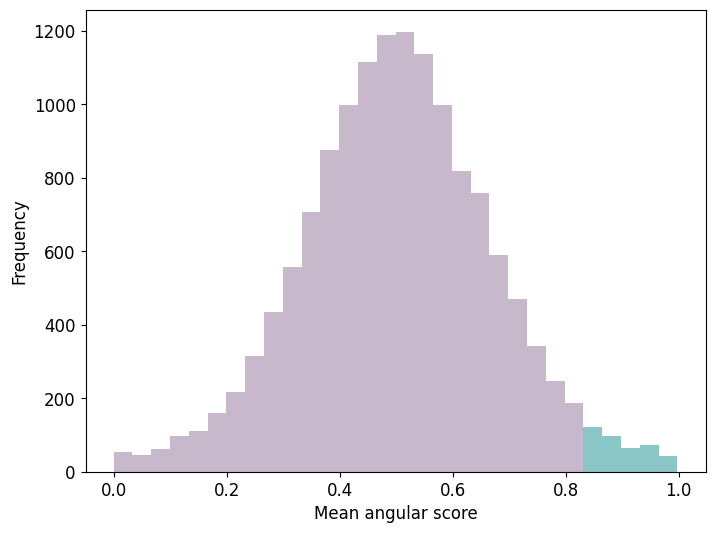

Proportion of data with mean angular score above 0.8 for C_114 symmetry: 0.041016179392563155


In [14]:
symm_type = 114

vlp_twist_desc_symm = tango.TwistDescriptor(input_motl= vlp_motl, nn_radius= radius, symm= symm_type)

cylinder_supp_symm = tango.Cylinder(vlp_twist_desc_symm, radius=radius, height=radius / 15, axis = np.array([0,0,-1]), symmetric= False)

z_axis_filtered_symm = tango.AxisRot(twist_desc= cylinder_supp_symm.support, max_angle= max_angle)

df = z_axis_filtered_symm.filter.df.copy()

df = df[df['euclidean_distance'] < 35] ## to catch the first shells.

mean_distances_whole = df.groupby(['qp_id', 'tomo_id'])['angular_score'].mean().to_dict()

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})

# Compute histogram and keep patches to modify individual bars
counts, bins, patches = plt.hist(mean_distances_whole.values(), bins=30, color=monet_colors[5], alpha=0.7)

# Paint bars to the right of x = 0.8 in green
for bin_left, patch in zip(bins[:-1], patches):
    if bin_left >= 0.8:
        patch.set_facecolor(monet_colors[2])

plt.xlabel('Mean angular score')
plt.ylabel('Frequency')

plt.show()

###
data = df.groupby(['qp_id', 'tomo_id'])['angular_score'].mean().to_numpy()
print(f"Proportion of data with mean angular score above 0.8 for C_{symm_type} symmetry: {np.count_nonzero(data >= 0.8) / len(data)}")

Some observations / notes regarding the computation of the mean angular score under the assumption of differen C_n symmetries:

The cut-off of considering mean angular scores above 0.8 was arbitrarily chosen. The focus herein lay in a strict notion of hexagonal regularity.

The notion of angular score is relative. Furthermore, it is normalized, making it possible to compare different C_n symmetries.

Comparison of C_n symmetries for different values of n > 1 shows a preference for C_6 symmetry in the data at hand. 

C_{k*6} symmetries, for k >= 1, show decreasing ratios for data with mean angular scores above the fixed threshold of 0.8.

For some C_n symmetries, n neither a multiple nor a divisor of 6, the above plot approaches a normal distribution. Compare for example the cases C_6 and C_5.